# Walmart Quarterly Sales Analysis and Prediction

### 2.1)Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder , FunctionTransformer , LabelEncoder , PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score ,mean_absolute_percentage_error , accuracy_score
from sklearn.tree import DecisionTreeRegressor ,plot_tree ,DecisionTreeClassifier
from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.neighbors import KNeighborsRegressor , KNeighborsClassifier
from statsmodels.tsa.seasonal import seasonal_decompose


### 2.2) Loading the Dataset

In [5]:
df= pd.read_csv("Walmart.csv")

In [6]:
df["Date"]=pd.to_datetime(df["Date"], format='%d-%m-%Y')


### 3.4.1) Removing Outliers of Weekly Sales

In [7]:
print(df["Weekly_Sales"].min())
print(df["Weekly_Sales"].max())
print(df["Weekly_Sales"].std())
print(df["Weekly_Sales"].mean())

percentile25=df["Weekly_Sales"].quantile(0.25)
percentile75=df["Weekly_Sales"].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit_weekly_sales=percentile75 +1.5 * iqr
lower_limit_weekly_sales=percentile75 -1.5 * iqr
print("Upper Limit:",upper_limit_weekly_sales)
print("Lower Limit:",lower_limit_weekly_sales)

print("Weekly Sales Above Upper Limit Data Points",df[df["Weekly_Sales"]>upper_limit_weekly_sales].shape)

print("Weekly Sales Below Lower Limit Data Points",df[df["Weekly_Sales"]<lower_limit_weekly_sales].shape)

df = df[df["Weekly_Sales"] < upper_limit_weekly_sales]



209986.25
3818686.45
564366.6220536975
1046964.8775617715
Upper Limit: 2720371.4924999997
Lower Limit: 119945.8274999999
Weekly Sales Above Upper Limit Data Points (34, 8)
Weekly Sales Below Lower Limit Data Points (0, 8)


In [8]:
quarterly_df = df.copy()

# Quarterly Data Prediction

In [9]:
quarterly_df["Quarterly"] = quarterly_df["Date"].dt.to_period("Q").dt.to_timestamp()
quarterly_df = quarterly_df.groupby("Quarterly")[["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]].sum()


### Train Test Split 

In [10]:
# Prepare features and target
X_quarterly = quarterly_df[["Temperature", "Fuel_Price", "CPI", "Unemployment"]]
y_quarterly = quarterly_df["Weekly_Sales"]

X_train_quarterly, X_test_quarterly, y_train_quarterly, y_test_quarterly = train_test_split(X_quarterly, y_quarterly, test_size=0.2, random_state=4)


### Transformation 

In [11]:
trf = FunctionTransformer( func = np.log1p , validate = True)

In [12]:
X_train_trans_quarterly = trf.fit_transform(X_train_quarterly)
X_test_trans_quarterly = trf.transform(X_test_quarterly)
y_train_trans_quarterly = trf.fit_transform(y_train_quarterly.values.reshape(-1, 1))
y_test_trans_quarterly = trf.transform(y_test_quarterly.values.reshape(-1, 1))

### Scaling

In [14]:
scaler = StandardScaler()

In [15]:
# Scale the features
X_train_scaled_quarterly = scaler.fit_transform(X_train_trans_quarterly)
X_test_scaled_quarterly = scaler.transform(X_test_trans_quarterly)

# Scale the target
y_train_scaled_quarterly = scaler.fit_transform(y_train_trans_quarterly)
y_test_scaled_quarterly = scaler.transform(y_test_trans_quarterly)

In [16]:
X_train_scaled_quarterly

array([[ 0.67345383,  0.79972226,  0.54664422,  0.32353816],
       [-0.17062729,  0.64936483,  0.53358228,  0.35228174],
       [ 0.93699208, -0.02376327,  0.43198326,  0.6316063 ],
       [-2.04805014, -2.20123826, -2.56317168, -2.6800184 ],
       [-1.39976668, -1.29633182, -0.85956794, -0.48726879],
       [ 0.57486718,  0.06240761,  0.42603497,  0.65134236],
       [ 0.55170753,  0.81775532,  0.47952497,  0.55044311],
       [-0.04003185,  0.47535799,  0.45389402,  0.39460608],
       [ 0.92145534,  0.71672533,  0.5510759 ,  0.26346944]])

### Linear Regression 

In [20]:
# Linear Regression
# Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled_quarterly, y_train_scaled_quarterly)

# Predict on test data
y_pred_lr = lr.predict(X_test_scaled_quarterly)

# Inverse scaling and transformation
# Assuming scaler_y is used for scaling the target variable (y)
y_test_inv_trans = scaler.inverse_transform(y_test_scaled_quarterly)
y_pred_lr_inv_trans = scaler.inverse_transform(y_pred_lr.reshape(-1, 1))  # Reshape for inverse transform

y_test_inv = np.expm1(y_test_inv_trans)  # Inverse log transformation
y_pred_lr_inv = np.expm1(y_pred_lr_inv_trans)  # Inverse log transformation

# Evaluation
mape_lr = mean_absolute_percentage_error(y_test_inv, y_pred_lr_inv) * 100
print("Linear Regression MAPE Score:", mape_lr)

mae_lr = mean_absolute_error(y_test_inv, y_pred_lr_inv)
print("Linear Regression MAE:", mae_lr)

# Create DataFrame for comparison
results_df_lr = pd.DataFrame({
    'Actual Weekly Sales': y_test_inv.flatten(),
    'Predicted Weekly Sales': y_pred_lr_inv.flatten()
})

# Display the first few rows of the results DataFrame
print("\nLinear Regression Comparison of Actual and Predicted Weekly Sales:")
results_df_lr.head(10)  # Display the first 10 rows


Linear Regression MAPE Score: 3.3464487577380146
Linear Regression MAE: 18983411.562210243

Linear Regression Comparison of Actual and Predicted Weekly Sales:


,Actual Weekly Sales,Predicted Weekly Sales
0,6.474560e+08,6.387562e+08
1,5.293917e+08,5.647561e+08
2,6.393585e+08,6.522446e+08


### Decision Tree

In [23]:
# Decision Tree Regression
# Train Decision Tree model
dt = DecisionTreeRegressor(max_depth=3, min_samples_split=4, min_samples_leaf=2)
dt.fit(X_train_scaled_quarterly, y_train_scaled_quarterly)

# Predict on test data
y_pred_dt = dt.predict(X_test_scaled_quarterly)

# Inverse scaling and transformation
# Assuming scaler_y is used for scaling the target variable (y)
y_test_inv_trans = scaler.inverse_transform(y_test_scaled_quarterly)
y_pred_dt_inv_trans = scaler.inverse_transform(y_pred_dt.reshape(-1, 1))  # Reshape for inverse transform

y_test_inv = np.expm1(y_test_inv_trans)  # Inverse log transformation
y_pred_dt_inv = np.expm1(y_pred_dt_inv_trans)  # Inverse log transformation

# Evaluation
mape_dt = mean_absolute_percentage_error(y_test_inv, y_pred_dt_inv) * 100
print("Decision Tree MAPE Score:", mape_dt)

mae_dt = mean_absolute_error(y_test_inv, y_pred_dt_inv)
print("Decision Tree MAE:", mae_dt)

# Create DataFrame for comparison
results_df_dt = pd.DataFrame({
    'Actual Weekly Sales': y_test_inv.flatten(),
    'Predicted Weekly Sales': y_pred_dt_inv.flatten()
})

# Display the first few rows of the results DataFrame
print("\nDecision Tree Comparison of Actual and Predicted Weekly Sales:")
results_df_dt.head(10)

Decision Tree MAPE Score: 10.383659924929157
Decision Tree MAE: 60678046.54306793

Decision Tree Comparison of Actual and Predicted Weekly Sales:


,Actual Weekly Sales,Predicted Weekly Sales
0,6.474560e+08,5.952016e+08
1,5.293917e+08,6.150146e+08
2,6.393585e+08,5.952016e+08


### KNN

In [35]:
knn = KNeighborsRegressor(n_neighbors=5)

knn.fit(X_train_scaled_quarterly, y_train_scaled_quarterly)

y_pred_knn = knn.predict(X_test_scaled_quarterly)

y_test_inv_trans = scaler.inverse_transform(y_test_scaled_quarterly.reshape(-1, 1))  # Reshape for inverse transform
y_pred_knn_inv_trans = scaler.inverse_transform(y_pred_knn.reshape(-1, 1))  # Reshape for inverse transform

# Apply inverse log transformation
y_test_inv = np.expm1(y_test_inv_trans)  # Inverse log transformation
y_pred_knn_inv = np.expm1(y_pred_knn_inv_trans)  # Inverse log transformation

# Calculate evaluation metrics
mape_knn = mean_absolute_percentage_error(y_test_inv, y_pred_knn_inv) * 100
print("KNN MAPE Score:", mape_knn)

mae_knn = mean_absolute_error(y_test_inv, y_pred_knn_inv)
print("KNN MAE:", mae_knn)

# Create DataFrame for comparison
results_df_knn = pd.DataFrame({
    'Actual Weekly Sales': y_test_inv.flatten(),
    'Predicted Weekly Sales': y_pred_knn_inv.flatten()
})

# Display the first few rows of the results DataFrame
print("\nKNN Comparison of Actual and Predicted Weekly Sales:")
results_df_knn.head(3)

KNN MAPE Score: 8.98327725580583
KNN MAE: 51940719.85068449

KNN Comparison of Actual and Predicted Weekly Sales:


,Actual Weekly Sales,Predicted Weekly Sales
0,6.474560e+08,6.070114e+08
1,5.293917e+08,6.111820e+08
2,6.393585e+08,6.057711e+08


# Graphical Comparison

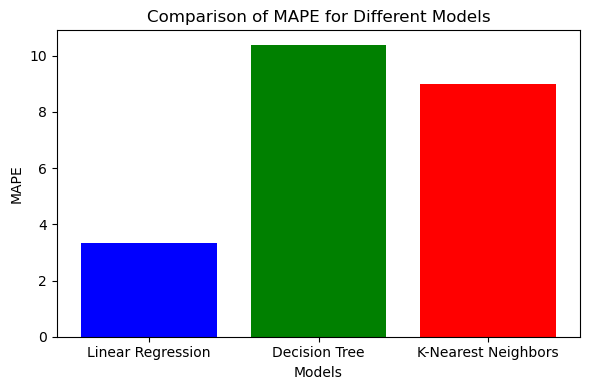

In [36]:
models = ['Linear Regression', 'Decision Tree', 'K-Nearest Neighbors']
mape_scores = [mape_lr, mape_dt, mape_knn]
plt.figure(figsize=(6, 4))
plt.bar(models, mape_scores, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('MAPE')
plt.title('Comparison of MAPE for Different Models')

plt.tight_layout()
plt.show()